# Atividade: MLPKerasClassifier

Implemente utilizando a API do scikit-learn um MLP para classificação usando Keras.

A implementação deve lidar dataset binários e multiclasse sem a necessidade de enviar parâmetros indicando qual o tipo da base.

A quantidade de neurônios nas camadas intemediárias e a função de ativação usada nelas deve poder ser passada pelo construtor.

#### Geração de bases de dados

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize

def criaDatasetXOR(n=1000):
    '''
    Cria dataset XOR, não linearmente separável.
    Será necessária uma camada oculta para resolver. 
    '''
    X,y = make_blobs(n_samples=n,centers=[[0,0],[1,0],[1,1],[0,1]],cluster_std=0.1)
    y = np.array(y%2,dtype=int)
    return X,y

def criaDatasetXOR_Multiclasse(n=20, n_classes=3):
    '''
    Cria dataset XOR, não linearmente separável.
    Mesmo do anterior, mas com varias classes
    '''
    X,y = make_blobs(n_samples=n,
                     centers=n_classes**2,
                     cluster_std=0.8)
    y = np.array(y%n_classes,dtype=int)
    return X,y

# Funções de plot

In [2]:
def plotDataSet(X,y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    
    for k in set(y):
        #print("k=",k)
        plt.plot(X[:,0][y==k],
                 X[:,1][y==k],
                 "o",alpha=0.3)

def plotHiperplano(X,y,vetor, intercept=0):
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    
    xs = np.linspace(x0min, x0max, num=2)
    #separador do hiperplano entre duas classificações pode ser 
    #encontrada conforme calculo abaixo:
    ys = (-vetor[0]/vetor[1])*xs-intercept/vetor[1]
    plt.plot(xs,ys)

Quanto temos uma situação em que a solução não é linearmente separável, precisamos criar uma camada oculta com pelo menos 2 neuronios, cuja função de ativação seja não linear.

Vamos criar uma nova função de plot para mostrar as regiões e não exatamente os pontos.

In [3]:
def define_axes(X, margem=0.1):
    '''
    A função retorna os eixos com a margem de 0.1
    O vetor será o mínimo até o máximo de cada um; esses são os eixos em que faremos a distribuição.
    '''
    #o mínimo e máximo da característica 1
    min1 = X[:,0].min()
    max1 = X[:,0].max() 

    min2 = X[:,1].min()
    max2 = X[:,1].max() 

    #colocando margem para baixo e margem pra cima de 10%
    return [min1-margem, max1+margem, min2-margem, max2+margem] #margem idel é .1 é o mesmo que 0.1

def plotPredictions(clf, X):
    '''
    Recebe um classificador e a matriz de características e exibe um gráfico utilizando meshgrid.
    '''
    axes = define_axes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0,x1 = np.meshgrid(x0s, x1s) #está fazendo a distribuição nxn, gerando duas matrizes
    X_ = np.c_[x0.ravel(), x1.ravel()] #c_ = cópia
    ypred  = clf.predict(X_).reshape(x0.shape)
    plt.contourf(x0,x1,ypred,cmap=plt.cm.brg, alpha=0.2)

A seguir, criaremos a classe MLP com Keras.

Note que o predict praticamente não mudou desde a última atividade, porém, o fit está totalmente adaptado ao uso da biblioteca do Keras.
Mantive os parâmetros básicos de configuração da rede. Achei muito útil o uso do parâmetro use_multiprocessing=True no fit do modelo. Acelerou bem o tempo de treinamento.

O passo a passo de definição da rede segue basicamente o mesmo que vimos em sala de aula:<br>
1 - Faz o yhot_encode dos doados de entrada <br>
2 - InputLayer com quantidade de neurônios conforme a quantidade de características base de dados<br>
3 - Adiciona as camadas intermediárias conforme parametrização passando a função de ativação parametrizada<br>
4 - Como precisamos construir uma rede tal que possa processar tanto bases binárias quanto multiclasse, precisamos observar que a definição da quatidade de neurônios da última camada deve ser conforme a base de dados. A função de ativação softmax pode ser usada em ambos casos, portanto foi escolhida.<br>
5 - Chama o fit<br>

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.utils import to_categorical

class MLPKerasClassifier(BaseEstimator, ClassifierMixin):
    '''
    Rede neural para classificação utilizando Keras.
    '''
    def __init__(self, n_hidden=[5,4], activation_function='relu', epochs=1000):
        self.n_hidden = n_hidden
        self.activation_function = activation_function
        self.epochs = epochs
    
    def fit(self, X, y):
        #adicionar ao self no final
        self.labels,ids = np.unique(y,return_inverse=True)
        
        #tratando caso binario ou multiclasse
        yhot = keras.utils.to_categorical(ids)
        size_last_layer = yhot.shape[1]
        size_first_layer = X.shape[1]
        
        if len(self.n_hidden) == 0:
            raise Exception('Parâmetro inválido: n_hidden!')
        else:
            #inicia o modelo
            model = keras.models.Sequential()
            model.add(layers.InputLayer(input_shape=(size_first_layer,)))

            #para cada elemento da lista, adicionar uma camada densa com a quantidade de neurônios conforme valor.
            for idx in range(len(self.n_hidden)):
                value = self.n_hidden[idx]
                model.add(layers.Dense(value, activation=self.activation_function))

            #na última camada, função softmax pra ser capaz de classificar bases binárias ou multiclasse
            model.add(layers.Dense(size_last_layer,activation='softmax'))

            model.compile(optimizer="rmsprop",
                            loss='categorical_crossentropy', #p´recisa ser categorial_... porque a base pode ser multiclasse
                            metrics=['accuracy'])
            
            model.fit(X,yhot,epochs=self.epochs,use_multiprocessing=True, verbose=0)
            self.coef_ = model.get_weights() 
            
            #salva o modelo
            self.model = model
        

    def predict(self, X, y=None):
        a = self.model.predict(X)
        idx = np.argmax(a, axis=1)
        ypred = self.labels[idx]
        return ypred

## Base Binária

Como primeiro teste, passaremos apenas a função 'relu' como ativação para uma base com 200 amostras e não faremos divisão entre treino e teste.

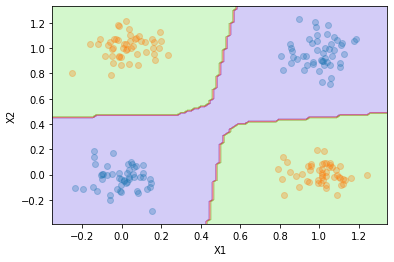

In [12]:
keras.backend.clear_session()

X,y = criaDatasetXOR(n=200)

mlpk = MLPKerasClassifier(n_hidden=[5], activation_function='relu', epochs=1000)
mlpk.fit(X, y)
ypred = mlpk.predict(X)

plotDataSet(X,y)
plotPredictions(mlpk, X)


Agora estenderemos o exemplo e veremos como o modelo se comporta com as funções de ativação tanh','sigmoid' e 'relu'.

Função tanh


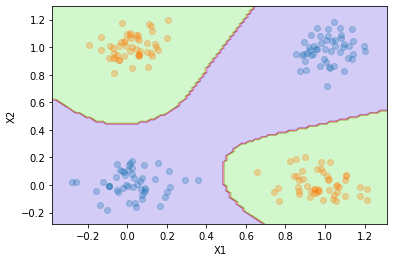

Função sigmoid


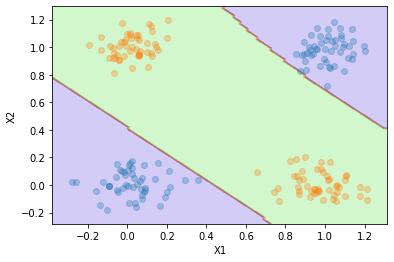

Função relu


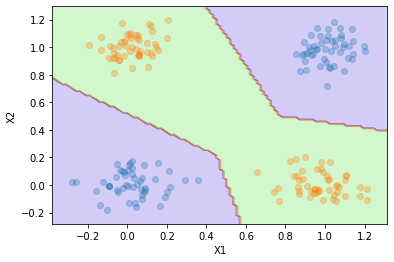

In [15]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

funcoes = ['tanh','sigmoid','relu']
X,y = criaDatasetXOR(n=200)

print('--- TREINO ---')
i=0
for funcao in funcoes:
    mlp = MLPKerasClassifier(n_hidden=[5], epochs=1000, activation_function=funcao)
    mlp.fit(X,y)
    print("Função " + funcoes[i])

    plotDataSet(X,y)
    plotPredictions(mlp, X)
    plt.show()

    i += 1

Aparentemente o modelo aprendeu bem com as três funções passadas para a base de dados indicada.
Agora, vamos ver como o modelo se comporta com divisão de treino e testes e vamos passar 1000 amostras iniciais.

--- TESTES ---
Função tanh


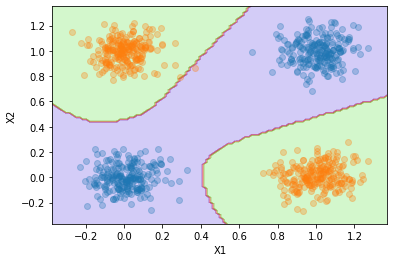

Função sigmoid


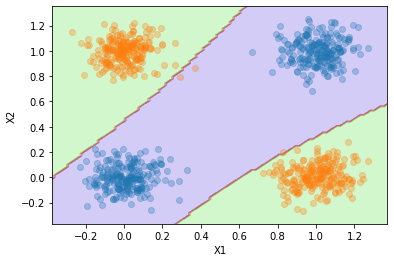

Função relu


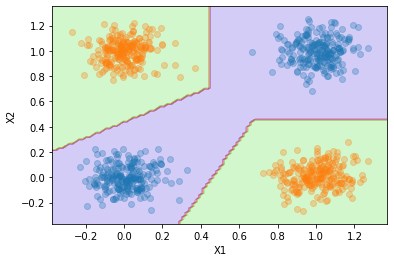

In [16]:
X,y = criaDatasetXOR(n=1000)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.9)

i=0
print('--- TESTES ---')
for funcao in funcoes:
    mlp = MLPKerasClassifier(n_hidden=[5], epochs=1000, activation_function=funcao)
    mlp.fit(Xtr,ytr)
    print("Função " + funcoes[i])

    plotDataSet(Xte,yte)
    plotPredictions(mlp, Xte)
    plt.show()

    i += 1

Podemos observar que as três funções funcionaram bem também nos testes.
Vamos agora passar para as bases de dados multiclasse.

## Base Multiclasse

Como primeiro teste, passaremos apenas a função 'relu' como ativação para uma base com 200 amostras e não faremos divisão entre treino e teste.

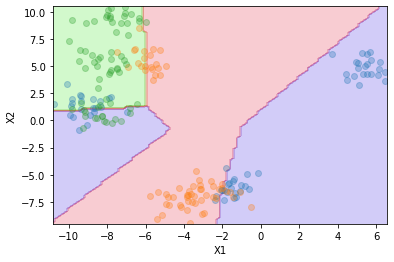

In [17]:
X,y = criaDatasetXOR_Multiclasse(n=200, n_classes=3)

mlpk = MLPKerasClassifier(n_hidden=[5], activation_function='relu', epochs=1000)
mlpk.fit(X, y)
ypred = mlpk.predict(X)

plotDataSet(X,y)
plotPredictions(mlpk, X)


Observamos que neste caso o resultado não foi bom. Provável que n_hidden=[5] tenha sido insuficiente. Vamos, então, aumentar a quantidade de camadas e reavaliar.

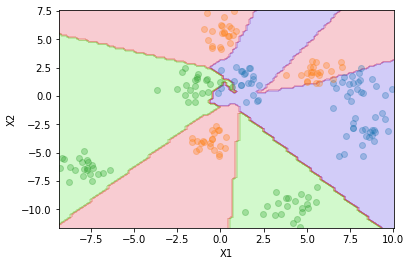

In [21]:
X,y = criaDatasetXOR_Multiclasse(n=200, n_classes=3)

mlpk = MLPKerasClassifier(n_hidden=[16, 8], activation_function='relu', epochs=1000)
mlpk.fit(X, y)
ypred = mlpk.predict(X)

plotDataSet(X,y)
plotPredictions(mlpk, X)


Resultado bem mais interessante. Vamos aumentar para 4 classes e tentar aumentar as camadas e verificar o resultado.

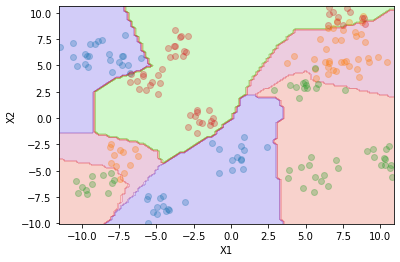

In [22]:
X,y = criaDatasetXOR_Multiclasse(n=200, n_classes=4)

mlpk = MLPKerasClassifier(n_hidden=[16, 8, 4], activation_function='relu', epochs=1000)
mlpk.fit(X, y)
ypred = mlpk.predict(X)

plotDataSet(X,y)
plotPredictions(mlpk, X)


Ok, ainda um bom resultado. Agora vamos aplicar uma base de 500 amostras com treino e testes sobre as três funções de ativação com essa mesma quantidade de camadas.

--- TESTES ---
Função tanh


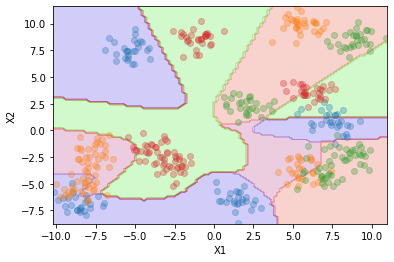

Função sigmoid


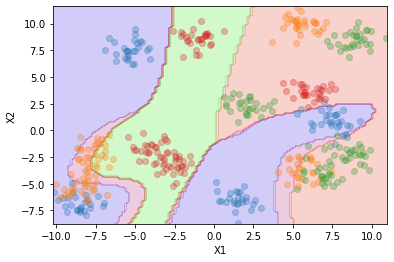

Função relu


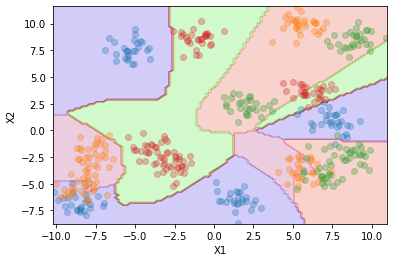

In [26]:
X,y = criaDatasetXOR_Multiclasse(n=500, n_classes=4)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.9)

i=0
print('--- TESTES ---')
for funcao in funcoes:
    mlp = MLPKerasClassifier(n_hidden=[64, 32, 16], epochs=1000, activation_function=funcao)
    mlp.fit(Xtr,ytr)
    print("Função " + funcoes[i])

    plotDataSet(Xte,yte)
    plotPredictions(mlp, Xte)
    plt.show()

    i += 1

Aumentando o número de neurônios e camadas ajudou a convergir nas três funções de ativação com bom resultado também nos testes.